Description: in this notebook we show how to inspect the warnings of your test run.

# Import Libraries

In [73]:
import project_path

import matplotlib.pyplot as plt
import os
import pandas as pd
import pprint
import seaborn as sns
import sqlite3 as sl
from tqdm import tqdm
from typing import List, Any, Tuple, Dict
pp = pprint.PrettyPrinter(indent=4)

from lib.detectors import KS_Detector
from lib.inspector import Inspector
from lib.inspector import OneNightStandInspector
from lib.inspector import retrieve_relevant_file_paths
from lib.inspector import read_program
from lib.inspector import inspec_column_of
from lib.inspector import copy_bug
from lib.inspector import get_alarms_with_method
from lib.qmt import execute_programs
from lib.utils import iterate_over
from lib.utils import load_config_and_check

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters
Insert here the path to the relevant folders related to your test run.

In [74]:
EXP_FOLDER = "qmt_v20"
PATH_DATASET = "../warnings/bug_dataset/Qiskit_Bug_Dataset - main_dataset.csv"

# READ THE SQLITE DATABASE WITH CRASHES
SQL_PATH = os.path.join("..", "data", EXP_FOLDER, "qfl.db")
SQL_CONNECTION = sl.connect(SQL_PATH)

# SETTING FOR DIVERGENCE DETECTION
PVAL_COL = "divergence.ks.p-value" 
ALPHA_LEVEL = 0.05

# Read Program Pairs

In [75]:
# READ CRASHES
df_crash = pd.read_sql("""SELECT * from CRASHDATA""", SQL_CONNECTION)
# READ COMPLETE EXECUTIONS
df_data = pd.read_sql("""SELECT * from QFLDATA""", SQL_CONNECTION)
# CONSIDER BOTH
df_generated_programs = pd.concat(
    [df_data.assign(generated_a_crash=False),
     df_crash.assign(generated_a_crash=True)], axis=0)
# READ ANNOTATED BUGS
df_bugs = pd.read_csv(PATH_DATASET)
df_bugs = df_bugs.fillna("-")

print(f"Total (potentially divergent) comparisons: {len(df_data)}")
print(f"Total crash in programs: {len(df_crash)}")
print(f"\tcrashing source: {len(df_crash[~df_crash['exceptions.source'].isna()])}")
print(f"\tcrashing follow-up: {len(df_crash[~df_crash['exceptions.followup'].isna()])}")

Total (potentially divergent) comparisons: 29855
Total crash in programs: 12169
	crashing source: 0
	crashing follow-up: 12169


# Inspect Crashes

CRASH MESSAGE GROUPING:
The crash messages containing the substring on the left of '>' are substituted by the substring on the right.
Instruction id not found in equivalence library  >  Instruction id not found
qargs not in this circuit  >  qargs not in this circuit
too many subscripts in einsum  >  too many subscripts in einsum (numpy)
['Mismatch between run_config.parameter_binds', ' unbound parameters']  >  Mismatch between parameter_binds
Cannot bind parameters  >  Cannot bind parameters not present in the circuit
Duplicate declaration for gate 'rzx'  >  Duplicate declaration for gate 'rzx'
Gate or opaque call to 'subcircuit'  >  Gate or opaque call to 'subcircuit'
Cannot find gate definition for 'c3sx'  >  Cannot find gate definition for 'c3sx'
Cannot find gate definition for 'rzx'  >  Cannot find gate definition for 'rzx'
Duplicate declaration for gate 'ryy'  >  Duplicate declaration for gate 'ryy'
Unable to map source basis  >  Unable to map source basis
greater than maximum  > 

/tmp/ipykernel_43256/313001564.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


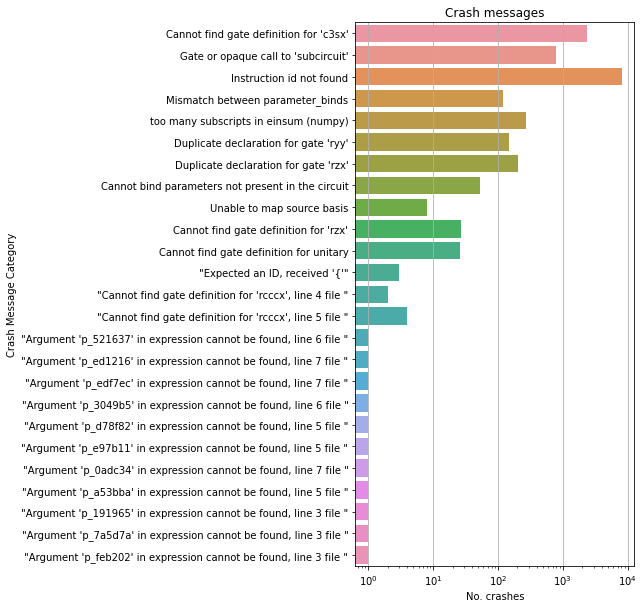

In [76]:
from copy import deepcopy

def normalize_names(df: pd.DataFrame, col: str, mapping:List[Tuple[str, str]]):
    """Replace the value of the given column according to the mapping.
    
    Each cell that contains the first string, will be replaced completely 
    with the second string of the tuple."""
    df = deepcopy(df)
    for hook, replacement in mapping:
        if isinstance(hook, list):
            for sub_hook in hook:
                df.loc[df[col].str.contains(sub_hook), col] = replacement
        else:
            df.loc[df[col].str.contains(hook), col] = replacement
    return df

exception_mapping = list(zip(df_bugs["hook_hint"], df_bugs["crash_category"]))
# remove spurious tuple ("-", "-") comuning from bugs detected via divergence
# in the dataset
exception_mapping = [
    e
    for e in exception_mapping
    if (e[0] != "-" and e[1] != "-")
]
# separate those with multiple hooks separated by the comma
# this happens because we might have multiple messages which maps back to the
# same crash category
exception_mapping = [
    (e[0].split(","), e[1]) if "," in e[0] else e 
    for e in exception_mapping
]

print("CRASH MESSAGE GROUPING:")
print("The crash messages containing the substring on the left of '>' are" +
      " substituted by the substring on the right.")
[print(e[0], " > ", e[1]) for e in exception_mapping]

df_crash_norm = normalize_names(
    df=df_crash, 
    col="exceptions.followup",
    mapping=exception_mapping
)

fig, ax = plt.subplots(figsize=(5, 10))

sns.countplot(
    data=df_crash_norm,
    y="exceptions.followup",
    ax=ax
)
ax.set_ylabel("Crash Message Category")
ax.set_xlabel("No. crashes")
ax.grid(axis='x')
ax.set_xscale('log')
#ax.set_xlim(0, 100)
ax.set_title("Crash messages")
plt.tight_layout()

# Inspect Divergences

In [65]:
program_ids_bonferroni = get_alarms_with_method(
    df=df_data, 
    pval_col=PVAL_COL,
    alpha_level=ALPHA_LEVEL,
    method='bonferroni')
program_ids_bonferroni

['bef8386c5f7346eba1df9def780bb84e',
 '2d939ba211fe43868f151e8137dab409',
 '6b66a08cb92c42bebaadb1bc5b2c5143',
 '8f10ee1b1f014c89bbf7b012c90ee028',
 '0ae6aeaaf6a84682b45578104ee70106',
 '9512a395017146d8996bc0c8d1618c7c',
 'ffcb06d7a9b941fea50e8d56355f6d87',
 '515aed9eaada431aa171d3deccc5e937',
 '33be42d869e8405bb5b92386a04df4fc',
 '6bc615a57eb44885b7e897ecc3290ca4',
 '389bcc01bba445f183b07fa8ed72b309',
 'ba53f83eda2146aa9f46fdd7cb957ec4',
 'ce9a5443fe944222a94af0a0c8e90ab8',
 'b4e837bd20bc49e5849376e849a5b75a',
 '159b5c5de5e44330a2ad0d34f2111f50',
 '25d4c0e336204c44b46d52ddfe24f007',
 'b0fe8481b86b4d6fbda42cdd49d0320a',
 '5f77a3f519bb4e3b9c08c73fd99a4bfc',
 'b5d0251b594f46638a8d8d9fd520a007',
 '348d7e30f6fe4690a4f1005baefbd060',
 '4fd94535fa604c8886f26cf45cebb9fa',
 '2a048277a5014341b145653ded299b92',
 '891d2a0503f74dc7a758617b8d1a8822',
 '4139c6451a96498a87df254dfadb9972',
 'de2c1ff7d6454f5d873b9bbd355c59cf',
 '2540c9261fff48f19eed2e0de9a6243c',
 '4ab3bb465c354aa6ab21e351fa49c2f3',
 

# Query programs [specific crash message]

In [70]:
QUERY_MESSAGE_CONTENT = "rcccx"  # change here

df_specific_class = df_crash[df_crash["exceptions.followup"].str.contains(QUERY_MESSAGE_CONTENT)]

print(f"We have {len(df_specific_class)} program pairs satisfying the query.")
PROGRAM_ID = df_specific_class.sort_values(by=[
    "source.n_qubits", "source.n_ops"
]).iloc[0]["program_id"]
print(f"The PROGRAM_ID of the first program pair is this: {PROGRAM_ID} ")

We have 6 program pairs satisfying the query.
The PROGRAM_ID of the first program pair is this: e04e2f8c07c74fa39e3dcfdff840dbf7 


# Inspect programs

In [71]:
PROGRAM_ID = PROGRAM_ID # CHANGE THIS MANUALLY 
# OR LEAVE IT THE SAME IF YOU WANT THE ONE FROM THE PREVIOUS STEP

In [72]:
BUG_PATHS = retrieve_relevant_file_paths(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID
)
print("PATH of {PROGRAM_ID} pair:")
pp.pprint(BUG_PATHS)
print("\nMetamorphic transformations used:")
pp.pprint(inspec_column_of(
    df=df_generated_programs, 
    program_id=PROGRAM_ID, 
    target_col="followup.metamorphic_transformations"
))

from termcolor import colored
print("READING SOURCE AND FOLLOWUP PROGRAMS")
print('# SOURCE')
read_program(path=BUG_PATHS['source'], color='red')
print("#" + "-" * 80)
print('# FOLLOWUP')
read_program(path=BUG_PATHS['followup'], color='blue')

PATH of {PROGRAM_ID} pair:
{   'followup': '../data/qmt_v20/programs/followup/e04e2f8c07c74fa39e3dcfdff840dbf7.py',
    'metadata': '../data/qmt_v20/programs/metadata/e04e2f8c07c74fa39e3dcfdff840dbf7.json',
    'metadata_exec': '../data/qmt_v20/programs/metadata_exec/e04e2f8c07c74fa39e3dcfdff840dbf7.json',
    'source': '../data/qmt_v20/programs/source/e04e2f8c07c74fa39e3dcfdff840dbf7.py'}

Metamorphic transformations used:
n hits: 1
['ChangeOptLevel', 'ToQasmAndBack', 'InjectNullEffect', 'AddUnusedRegister']
None
READING SOURCE AND FOLLOWUP PROGRAMS
# SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(6, name='qr')
cr = ClassicalRegister(6, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(IGate(), qargs=[qr[3]], cargs=[])
qc.append(UGate(0.759407884354721,2.7354296904983